In [1]:
from pathlib import Path
import numpy as np
import os

from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def get_images(root, dim=(960,330)):
    
    # classes that I need to be classified
    class_name = [dir_name for dir_name in os.listdir(root) 
                  if os.path.isdir(os.path.join(root,dir_name)) and dir_name != 'raw-images']
    
    images = []
    target = []
    flatten_data = []
    
    for i, direc in enumerate(class_name):
        for file in os.listdir(os.path.join(root, direc)):
            img = imread(os.path.join(root,direc,file))
            img_resized = resize(img, dim, anti_aliasing=True, mode='reflect')
            flatten_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    
    flatten_data = np.array(flatten_data)
    target = np.array(target)
    images = images
    
    return Bunch(data=flatten_data,
                 target=target,
                 target_names=class_name,
                 images=images)

In [3]:
root = './b11b8b4-agriAnalysis'
image_dataset = get_images(root)
print(image_dataset.data.shape)


(61, 950400)


### splitting data

In [4]:
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    image_dataset.data, image_dataset.target, image_dataset.images, test_size=0.2,random_state=101)

### model & train data with parameter optimization

In [5]:
%%time
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)

d:\campuz\4 yr\research-final\env\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
d:\campuz\4 yr\research-final\env\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 3min 10s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [6]:
print(clf.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [7]:
y_pred1 = clf.predict(X_train) # for check overfit

In [8]:
y_pred2 = clf.predict(X_test)

In [9]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_train, y_pred1)))

Classification report for - 
GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00     

### report

In [10]:
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test, y_pred2)))

Classification report for - 
GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.60      1.00      0.75         3
           2       1.00      0.40     

### Quntitative analysis

In [11]:
def plot_images(images, titles, n_row=3, n_col=4):
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=2, top=.90, hspace=.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [12]:
def title(y_pred, y_test, target_name, i):
    pred_name = target_name[y_pred[i]]
    true_name = target_name[y_test[i]]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [13]:
prediction_titles = [title(y_pred2, y_test, image_dataset.target_names, i) for i in range(y_pred2.shape[0])]

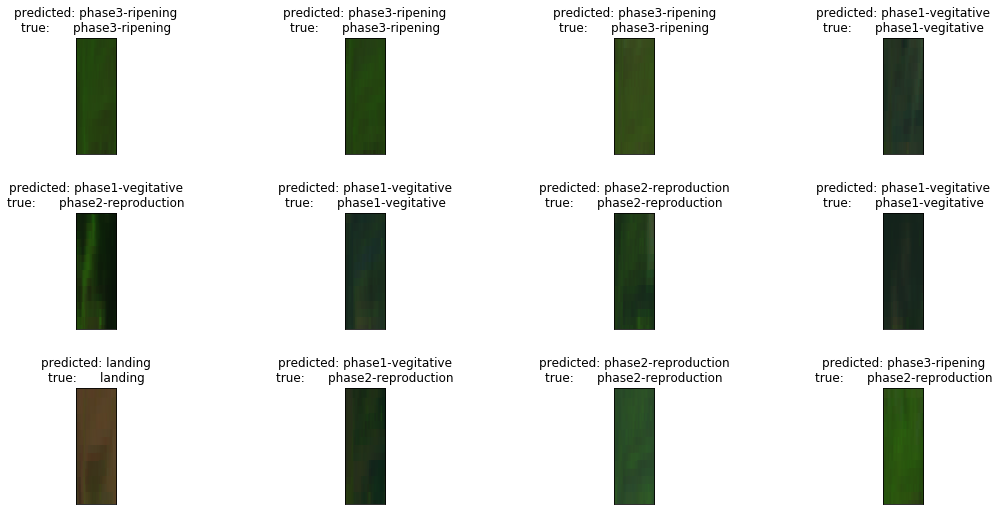

In [14]:
plot_images(img_test, prediction_titles)